# Unit Test Runner
This notebook allows a test suite to be created for any registered tests.

To use this functionality, use the `%run` magic command to load the test notebook and then update the test suite.

In [0]:
dbutils.library.installPyPI('unittest-xml-reporting')
dbutils.library.restartPython()

dbutils.library APIs are deprecated and will be removed in a future DBR release. You can use %pip and %conda commands to install notebook scoped python libraries. For more information see https://docs.microsoft.com/azure/databricks/libraries/notebooks-python-libraries.
PyPI package unittest-xml-reporting has been installed already. The previously installed package is `unittest-xml-reporting`. To resolve this issue, detach and re-attach the notebook to create a new environment or rename the package.

In [0]:
import xml.etree.ElementTree as ET
import pandas as pd
import unittest
import xmlrunner
import uuid
import io
import datetime
import json

In [0]:
%run ./log_analytics_tests

In [0]:
%run ./more_tests

In [0]:
from inspect import getmro

def get_class_hierarchy(t):
  try:
    return getmro(t)
  except:
    return [object]

test_classes = {t for t in globals().values() if unittest.case.TestCase in get_class_hierarchy(t) and t != unittest.case.TestCase}
print(test_classes)

loader = unittest.TestLoader()
suite = unittest.TestSuite()
for test_class in test_classes:
  tests = loader.loadTestsFromTestCase(test_class)
  suite.addTests(tests)

out = io.BytesIO()
runner = xmlrunner.XMLTestRunner(out)
runner.run(suite)

{<class '__main__.LogAnalyticsTests'>, <class '__main__.MoreTests'>}

Running tests...
----------------------------------------------------------------------
..F.
======================================================================
FAIL [0.000s]: test_always_fails (__main__.MoreTests)
----------------------------------------------------------------------
Traceback (most recent call last):
 File "<command-2641614281736560>", line 7, in test_always_fails
 self.assertTrue(False)
AssertionError: False is not true

----------------------------------------------------------------------
Ran 4 tests in 0.001s

FAILED (failures=1)

Generating XML reports...
Out[10]: <xmlrunner.result._XMLTestResult run=4 errors=0 failures=1>

In [0]:
out.seek(0)
test_results = ET.XML(out.read().decode('utf-8'))

ts = []
for suite in test_results:
  for test in suite:
    failures = [{k:v for k,v in failure.items()} for failure in test]
    if len(failures) > 0:
      for failure in failures:
        attributes = {k:v for k,v in suite.attrib.items()}
        attributes.update({f"test_{k}":v for k,v in test.attrib.items()})
        attributes.update({f"failure_{k}":v for k,v in failure.items()})
        ts.append(attributes)
    else:
      attributes = {k:v for k,v in suite.attrib.items()}
      attributes.update({f"test_{k}":v for k,v in test.attrib.items()})
      attributes.update({"failure_type":None, "failure_message":None})
      ts.append(attributes)
    
df = pd.DataFrame(ts)
df["tests"] = df["tests"].astype(int)
df["errors"] = df["errors"].astype(int)
df["failures"] = df["failures"].astype(int)
df["skipped"] = df["skipped"].astype(int)
df["succeeded"] = df["tests"] - (df["errors"] + df["failures"] + df["skipped"])
df = df.loc[:, ["timestamp", "name", "time", "tests", "succeeded", "errors", "failures", "skipped", "test_name", "test_time", "failure_type", "failure_message"]]
df

Out[11]:

,timestamp,name,time,tests,succeeded,errors,failures,skipped,test_name,test_time,failure_type,failure_message
0,2021-03-19T00:30:30,LogAnalyticsTests-20210319003030,0.001,2,2,0,0,0,test_build_signature,0.000,None,None
1,2021-03-19T00:30:30,LogAnalyticsTests-20210319003030,0.001,2,2,0,0,0,test_log_analytics_logs_message,0.000,None,None
2,2021-03-19T00:30:30,MoreTests-20210319003030,0.000,2,1,0,1,0,test_always_succeeds,0.000,None,None
3,2021-03-19T00:30:30,MoreTests-20210319003030,0.000,2,1,0,1,0,test_always_fails,0.000,AssertionError,False is not true


Out[12]:

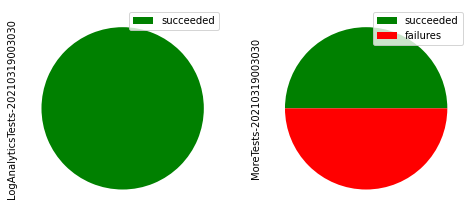

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f8c321d30>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7f1f8c28c250>],
 dtype=object)

In [0]:
idx = df.groupby(["name", "tests", "succeeded", "errors", "failures", "skipped"]).first().index
columns = idx.name

gf = pd.DataFrame([[x for x in t] for t in idx], columns=idx.names)
gf.index = gf["name"]
gf = gf.iloc[:,2:]
gf.T.plot.pie(subplots=True, colors=['green', 'red', 'red', 'yellow'], labeldistance=None, figsize=(8,8))

In [0]:
out.seek(0)
dbutils.notebook.exit(out.read().decode('utf-8'))

<?xml version="1.0" encoding="UTF-8"?>
<testsuites>
	<testsuite name="LogAnalyticsTests-20210319003030" tests="2" file=".py" time="0.001" timestamp="2021-03-19T00:30:30" failures="0" errors="0" skipped="0">
		<testcase classname="LogAnalyticsTests" name="test_build_signature" time="0.000" timestamp="2021-03-19T00:30:30"/>
		<testcase classname="LogAnalyticsTests" name="test_log_analytics_logs_message" time="0.000" timestamp="2021-03-19T00:30:30"/>
	</testsuite>
	<testsuite name="MoreTests-20210319003030" tests="2" file=".py" time="0.000" timestamp="2021-03-19T00:30:30" failures="1" errors="0" skipped="0">
		<testcase classname="MoreTests" name="test_always_succeeds" time="0.000" timestamp="2021-03-19T00:30:30"/>
		<testcase classname="MoreTests" name="test_always_fails" time="0.000" timestamp="2021-03-19T00:30:30">
			<failure type="AssertionError" message="False is not true"><![CDATA[Traceback (most recent call last):
  File "<command-2641614281736560>", line 7, in test_always_fails
 